In [2]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X, Y = datasets.load_digits(return_X_y=True)

In [4]:
def binarize(Y, n):
    N = len(Y)
    data = np.zeros((N,n), 'd')
    rows = []
    for k in range(N):
        data[k, Y[k]] = 1
    data = 2*data-1
    return data

Y2 = binarize(Y, 10)
print(Y2.shape, X.shape)

(1797, 10) (1797, 64)


In [5]:
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score

In [6]:
def calc_zz(mod, xr, yr):
    xrange = np.linspace(xr[0], xr[1], 101)
    yrange = np.linspace(yr[0], yr[1], 101)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate_all(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

In [7]:
def plot_params(mod, ax=None):
    if ax is None:
        ax = plt.gca()
    ymax = np.asarray(mod.param.base[1:].copy())
    ymin = np.asarray(mod.param.base[1:].copy())
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    n = len(ymin)
    print(n)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    ax.legend(loc="upper right")


In [8]:
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.models as models
import mlgrad.funcs2 as funcs2
from mlgrad.cls import classification_as_regr
import mlgrad.plots as plots

In [35]:
hinge_loss = loss.MarginLoss(funcs.Hinge(0))
l2_reg = funcs2.SquareNorm()
l1_reg = funcs2.AbsoluteNorm()
sigmoidal_func = funcs.Sigmoidal(2.0)
sq_loss = loss.ErrorLoss(funcs.Square())

In [26]:
n_hidden = 10
body = models.FFNetworkModel()
body.add(models.LinearLayer(2, n_hidden))
body.add(models.ScaleLayer(funcs.Sigmoidal(6.0), n_hidden))
head = models.LinearModel(body.n_output)
nnmod = models.FFNetworkFuncModel(head, body)

In [27]:
nnmod.allocate()
nnmod.init_param()

In [62]:
alg = classification_as_regr(U2, Y2, nnmod,
                             lossfunc=loss.MarginMultiLoss(,
                             regnorm=l1_reg, tau=0.000,
                             h=0.001)

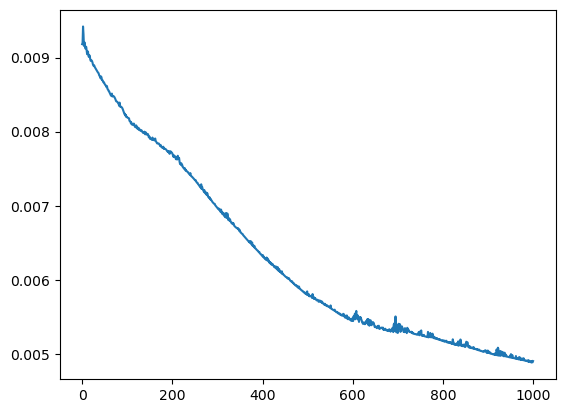

1.0

In [63]:
plt.plot(alg.lvals)
plt.show()
accuracy_score(Y2, np.sign(nnmod.evaluate_all(U2)))

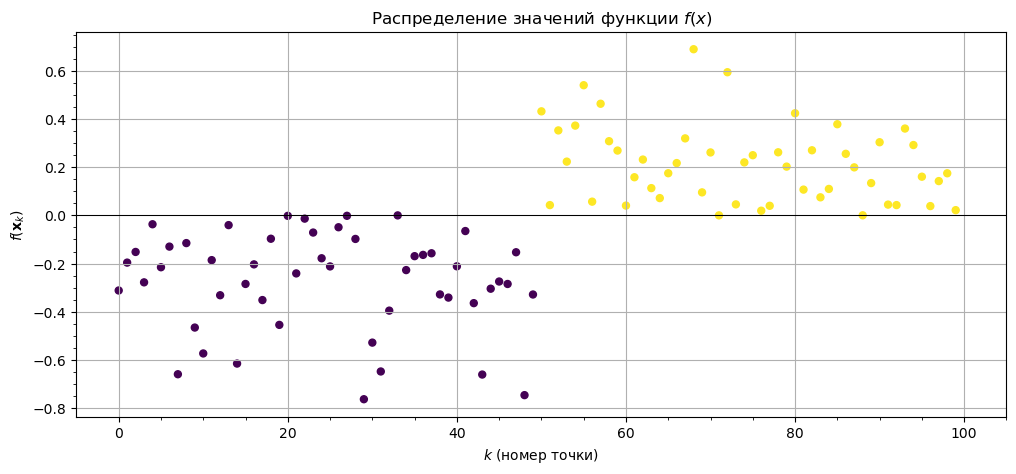

In [30]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(nnmod, U2, Y2)
plt.show()

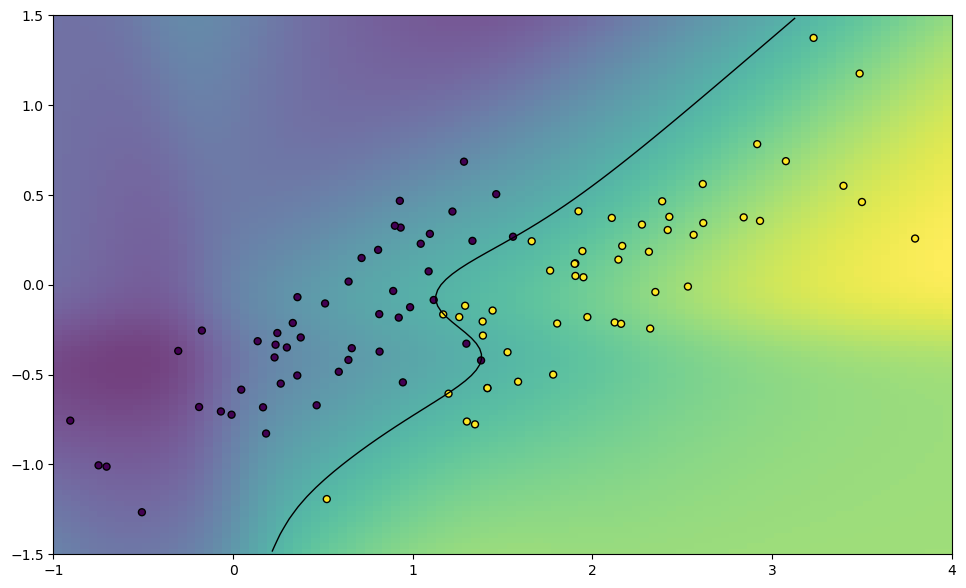

In [31]:
ZZ = calc_zz(nnmod, [-1.,4.], [-1.5,1.5])
plt.figure(figsize=(12,7))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=25)
plt.imshow(ZZ, origin='lower', extent=(-1., 4,-1.5, 1.5), alpha=0.75)
# plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-1.,4,-1.5, 1.5), linewidths=1, colors='k')
# plt.contour(ZZ, levels=[-1,1], origin='lower', extent=(-1.,4,-1.5, 1.5), linewidths=0.5, linestyles='--')
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.show()

40


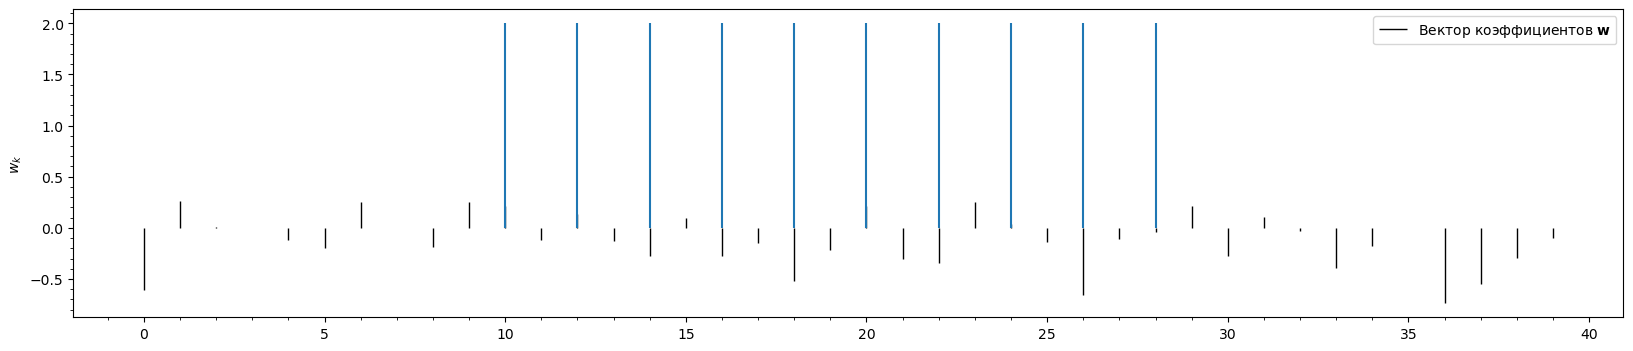

In [34]:
plt.figure(figsize=(20,4))
plot_params(nnmod)
plt.vlines([n_hidden+U2.shape[1]*i for i in range(n_hidden)], 0, 2)
plt.show()